# Power consumption forecasting using SARIMAX

In [1]:
library(readr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(xts)
library(fpp2)
library(DMwR)
library(Metrics)
library(tseries)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘xts’

The following objects are masked from ‘package:dplyr’:

    first, last

Loading required package: forecast
Loading required package: fma
Loading required package: expsmooth
Loading required package: lattice
Loading required package: grid

Attaching package: ‘DMwR’

The following object is masked from ‘package:fma’:

    sales


Attaching package: ‘Metrics’

The following object is masked from ‘package:forecast’:

    accuracy



In [2]:
options(repr.plot.width=8, repr.plot.height=4)

## 1. Data import

In [3]:
path <- '../data/power-consumption/processed_data.csv'
data <- read_csv(path)

Parsed with column specification:
cols(
  date = col_date(format = ""),
  Global_active_power = col_double(),
  Global_reactive_power = col_double(),
  Voltage = col_double(),
  Global_intensity = col_double(),
  Sub_metering_1 = col_double(),
  Sub_metering_2 = col_double(),
  Sub_metering_3 = col_double(),
  Sub_metering_4 = col_double(),
  Month = col_double(),
  Weekday = col_double(),
  WeekOfYear = col_double(),
  Median_active_power = col_double(),
  Lagged_active_power = col_double(),
  median_residual = col_double()
)


In [4]:
# discard selected columns
discard_cols <- c("Month", "Weekday", "WeekOfYear", "Lagged_active_power", "Median_active_power", "median_residual", "Sub_metering_4")
data <- select(data, -discard_cols)

In [5]:
head(data)
tail(data)
nrow(data)

date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2006-12-16,1209.176,34.922,236.2438,5180.8,0,546,4926
2006-12-17,3390.460,226.006,240.0870,14398.6,2033,4187,13341
2006-12-18,2203.826,161.792,241.2317,9247.2,1063,2621,14018
2006-12-19,1666.194,150.942,241.9993,7094.0,839,7602,6197
2006-12-20,2225.748,160.998,242.3081,9313.0,0,2648,14063
2006-12-21,1723.288,144.434,241.0392,7266.4,1765,2692,10456


date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2010-11-21,900.910,119.624,241.1802,3798.6,0,506,4778
2010-11-22,2041.536,142.354,240.1971,8660.4,4855,2110,10136
2010-11-23,1577.536,137.450,240.5755,6731.2,1871,458,7611
2010-11-24,1796.248,132.460,240.0310,7559.4,1096,2848,12224
2010-11-25,1431.164,116.128,241.5363,6004.0,1076,426,5072
2010-11-26,1488.104,120.826,240.2910,6259.8,1080,385,9989


[1] 1442

## 2. Convert to ts object

In [7]:
# define date range as per the data
date_range <- seq(as.Date('2006-12-16'), as.Date('2010-11-26'), by='day')

# no need to put the date column as it will generate as ts index
dayofyear <- as.numeric(format(date_range[1], '%j'))

power_data <- ts(data[, 2:8], start=c(2006, dayofyear), frequency = 365)

In [8]:
head(power_data)

Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
1209.176,34.922,236.2438,5180.8,0,546,4926
3390.460,226.006,240.0870,14398.6,2033,4187,13341
2203.826,161.792,241.2317,9247.2,1063,2621,14018
1666.194,150.942,241.9993,7094.0,839,7602,6197
2225.748,160.998,242.3081,9313.0,0,2648,14063
1723.288,144.434,241.0392,7266.4,1765,2692,10456


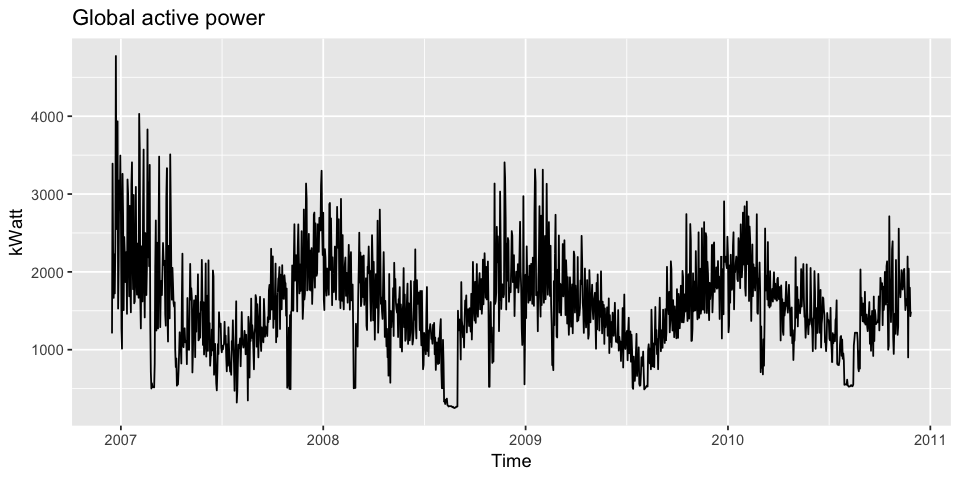

In [9]:
autoplot(power_data[, 1]) +
    ggtitle('Global active power') +
    ylab('kWatt')

## 3. Data analysis

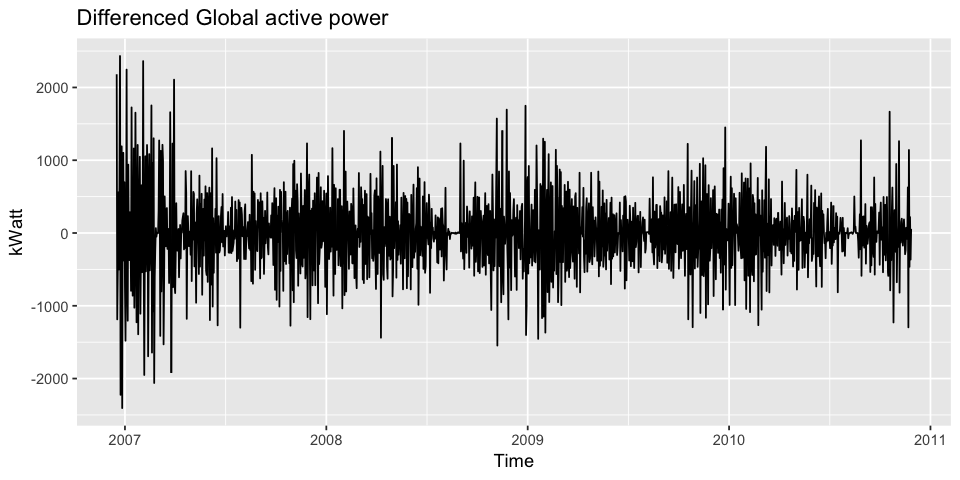

In [10]:
autoplot(diff(power_data[, 1])) +
    ggtitle('Differenced Global active power') +
    ylab('kWatt')

- The data seems to be I(1)

## 3. Train test split

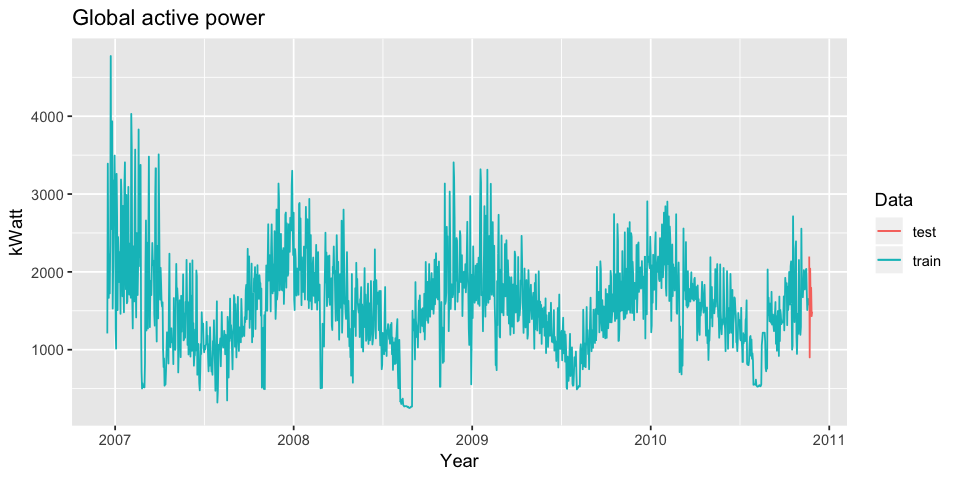

In [11]:
# train and test split
# last two weeks will be test set rest training set
# we will drop the explanatory  variables for baseline models
# as they will not be need for forecasting

test_size <- as.numeric(7*1)
train_size <- nrow(power_data)- test_size

train <- head(power_data, train_size)
test <- tail(power_data, test_size)

autoplot(train[, 1], series = 'train') + 
    autolayer(test[, 1], series = 'test') +
    ggtitle('Global active power') +
    ylab('kWatt') + 
    xlab('Year') +
    guides(colour=guide_legend(title="Data"))

In [12]:
tail(train[, 1])

Time Series:
Start = c(2010, 319) 
End = c(2010, 324) 
Frequency = 365 
[1] 2038.392 1747.382 1509.748 1582.032 1652.152 1570.400

In [13]:
head(test[, 1])

Time Series:
Start = c(2010, 325) 
End = c(2010, 330) 
Frequency = 365 
[1] 2197.006  900.910 2041.536 1577.536 1796.248 1431.164

In [14]:
head(train)

Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
1209.176,34.922,236.2438,5180.8,0,546,4926
3390.460,226.006,240.0870,14398.6,2033,4187,13341
2203.826,161.792,241.2317,9247.2,1063,2621,14018
1666.194,150.942,241.9993,7094.0,839,7602,6197
2225.748,160.998,242.3081,9313.0,0,2648,14063
1723.288,144.434,241.0392,7266.4,1765,2692,10456


In [15]:
exog_col <- colnames(train)[2:7]
exog <- train[, exog_col]

head(exog)

Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
34.922,236.2438,5180.8,0,546,4926
226.006,240.0870,14398.6,2033,4187,13341
161.792,241.2317,9247.2,1063,2621,14018
150.942,241.9993,7094.0,839,7602,6197
160.998,242.3081,9313.0,0,2648,14063
144.434,241.0392,7266.4,1765,2692,10456


## 4. Model fitting

In [16]:
# multi-step forecasting using SARIMAX
# use arima order determined in previous step
multistep_forecasting <- function(train, test, h=7){
                            fit <- Arima(train[, 1], order = c(1, 1, 1), seasonal = c(0, 1, 0), 
                                         xreg = exog, lambda = NULL)
                            saveRDS(fit, '../checkpoints/power/R-models/sarimax-v4.rds')
#                             fit <- readRDS('../checkpoints/power/R-models/sarimax-v4.rds')

                            train_pred <- fitted(fit)
                            
                            n <- length(test)
                            test_pred <- ts(numeric(n), start=c(2010, 325), freq=365)
    
                            test_exog <- test[, exog_col]
                            test_pred <- forecast(fit, h=h, xreg=test_exog)$mean
                            
                            output <- list(train=train_pred, test=test_pred, model=fit)
                            return(output) 
                            }

In [17]:
result = multistep_forecasting(train, test, h=7)

## 5. Model evaluation

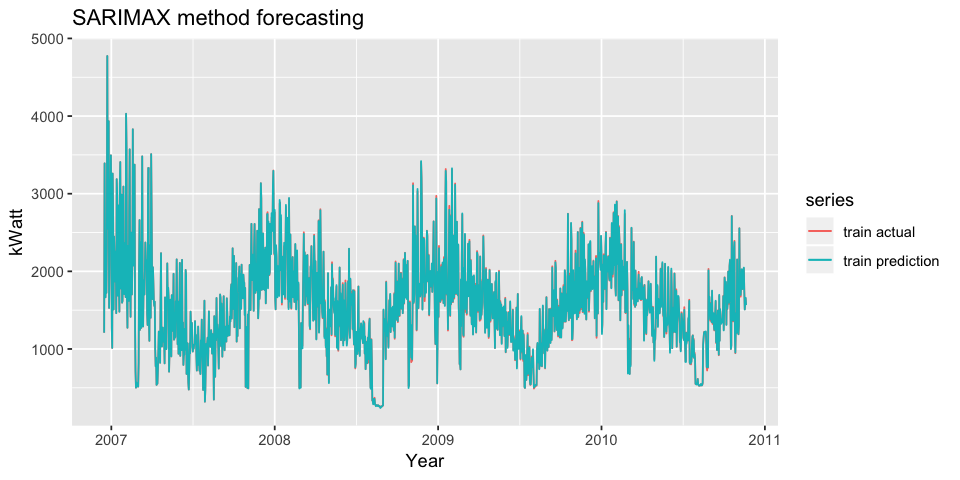

In [20]:
autoplot(train[, 1], series = 'train actual') +
    autolayer(result$train, series = 'train prediction') +
    xlab('Year') +
    ylab('kWatt') +
    ggtitle('SARIMAX method forecasting')

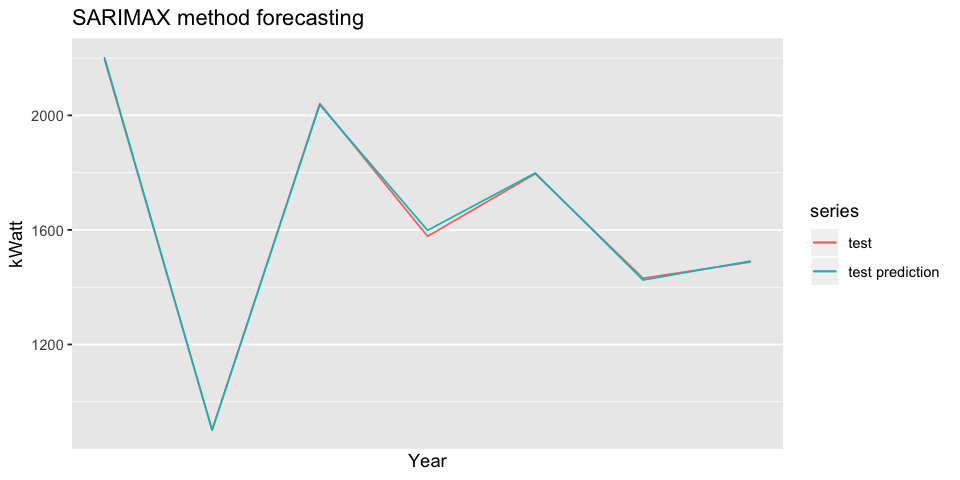

In [21]:
autoplot(test[, 1], series = 'test') +
    autolayer(result$test, series = 'test prediction') +
    xlab('Year') +
    ylab('kWatt') +
    ggtitle('SARIMAX method forecasting')

In [24]:
train_pred <- result$train
test_pred <- result$test

train_rmse <- sqrt(mse(train[, 1], train_pred))
train_mae <- mae(train[, 1], train_pred)
train_nrmse <- train_rmse/sd(train[, 1])

test_rmse <- sqrt(mse(test[, 1], test_pred))
test_mae <- mae(test[, 1], test_pred)
test_nrmse <- test_rmse/sd(test[, 1])

# print(paste0('Training RMSE :', round(train_rmse, 3)))
print(paste0('Training NRMSE :', round(train_nrmse, 03)))
print(paste0('Training MAE :', round(train_mae, 3)))

# print(paste0('Test RMSE :', round(test_rmse, 3)))
print(paste0('Test NRMSE :', round(test_nrmse, 3)))
print(paste0('Test MAE :', round(test_mae, 3)))

[1] "Training NRMSE :0.023"
[1] "Training MAE :8.813"
[1] "Test NRMSE :0.021"
[1] "Test MAE :6.375"


## 6. Residual and co-efficient analysis

Series: train[, 1] 
Regression with ARIMA(2,1,2)(0,1,0)[365] errors 

Coefficients:


Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”

          ar1      ar2      ma1      ma2  Global_reactive_power  Voltage
      -0.3549  -0.0607  -0.5785  -0.3324                      0    0e+00
s.e.   0.0000   0.0000   0.0000   0.0000                    NaN    1e-04
      Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3
                0.0000          0.0600          0.0600          0.0600
s.e.            0.0035          0.0034          0.0144          0.0028
      Sub_metering_4
              0.0600
s.e.          0.0022

sigma^2 estimated as 1.033e-23:  log likelihood=26598.14
AIC=-53172.28   AICc=-53171.98   BIC=-53112.67

Training set error measures:
                       ME         RMSE          MAE          MPE         MAPE
Training set 1.140451e-14 2.756549e-12 1.848784e-12 5.985786e-15 1.409375e-13
                    MASE         ACF1
Training set 3.95416e-15 -0.001933449

	Ljung-Box test

data:  Residuals from Regression with ARIMA(2,1,2)(0,1,0)[365] errors
Q* = 468.59, df = 274.6, p-value = 2.598e-12

Mode

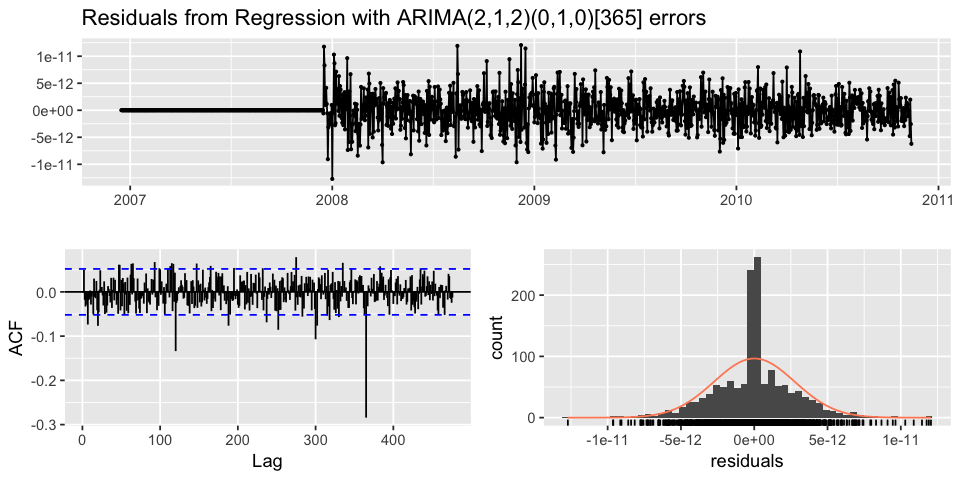

In [27]:
summary(result$model)
checkresiduals(result$model)